# Load Base Packages

In [1]:
import pandas as pd
import sys
import os
import warnings
import matplotlib.pyplot as plt
from sklearn.exceptions import ConvergenceWarning
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    average_precision_score,
)
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from scipy.stats import loguniform


warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore"

# Preprocess Data (Needed)

In [105]:
data = pd.read_csv("../00_original_data/adult.csv")
data = data.replace("?", None)
data["income"] = data["income"].replace(
    {"<=50K.": 0, "<=50K": 0, ">50K": 1, ">50K.": 1}
)
data.insert(0, "income", data.pop("income"))
data["native-country_United-States"] = (
    data["native-country"] == "United-States"
).astype(int)
data.drop("native-country", axis=1, inplace=True)

# grab numeric cols
numeric_cols = [
    "age",
    "education-num",
    "capital-gain",
    "capital-loss",
    "hours-per-week",
]
# grab categroical cols
categorical_cols = [
    "native-country_United-States",
    "workclass",
    "education",
    "marital-status",
    "occupation",
    "relationship",
    "race",
    "sex",
]

feature_names = data.columns.tolist()[1:]
print(feature_names)

# define categorical and numerical indices for later preprocessing
categorical_columns_indices = [feature_names.index(cn) for cn in categorical_cols]
numerical_columns_indices = [
    feature_names.index(fn) for fn in feature_names if fn not in categorical_cols
]

['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country_United-States']


In [109]:
encoder = OneHotEncoder(handle_unknown="ignore")
encoded_data = encoder.fit_transform(data[categorical_cols])

# Create DataFrame for encoded features with proper column naming
new_column_names = encoder.get_feature_names_out(categorical_cols)
encoded_df = pd.DataFrame(encoded_data.toarray(), columns=new_column_names)

In [110]:
encoded_df

,native-country_United-States_0,native-country_United-States_1,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,workclass_State-gov,workclass_Without-pay,...,relationship_Own-child,relationship_Unmarried,relationship_Wife,race_Amer-Indian-Eskimo,race_Asian-Pac-Islander,race_Black,race_Other,race_White,sex_Female,sex_Male
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
2,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
3,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
48838,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
48839,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
48840,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [111]:
# Drop the original categorical columns and join the encoded data
data = data.drop(categorical_cols, axis=1)
data = pd.concat([data, encoded_df], axis=1)

In [112]:
feature_names = data.columns.tolist()[1:]
feature_names

['age',
 'fnlwgt',
 'education-num',
 'capital-gain',
 'capital-loss',
 'hours-per-week',
 'native-country_United-States_0',
 'native-country_United-States_1',
 'workclass_Federal-gov',
 'workclass_Local-gov',
 'workclass_Never-worked',
 'workclass_Private',
 'workclass_Self-emp-inc',
 'workclass_Self-emp-not-inc',
 'workclass_State-gov',
 'workclass_Without-pay',
 'workclass_None',
 'workclass_nan',
 'education_10th',
 'education_11th',
 'education_12th',
 'education_1st-4th',
 'education_5th-6th',
 'education_7th-8th',
 'education_9th',
 'education_Assoc-acdm',
 'education_Assoc-voc',
 'education_Bachelors',
 'education_Doctorate',
 'education_HS-grad',
 'education_Masters',
 'education_Preschool',
 'education_Prof-school',
 'education_Some-college',
 'marital-status_Divorced',
 'marital-status_Married-AF-spouse',
 'marital-status_Married-civ-spouse',
 'marital-status_Married-spouse-absent',
 'marital-status_Never-married',
 'marital-status_Separated',
 'marital-status_Widowed',
 'oc

In [113]:
feature_names = data.columns.tolist()[1:]
# I don't this is neeeded at all
feature_names.remove("fnlwgt")
data.head()

,income,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,native-country_United-States_0,native-country_United-States_1,workclass_Federal-gov,...,relationship_Own-child,relationship_Unmarried,relationship_Wife,race_Amer-Indian-Eskimo,race_Asian-Pac-Islander,race_Black,race_Other,race_White,sex_Female,sex_Male
0,0,39,77516,13,2174,0,40,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
1,0,50,83311,13,0,0,13,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
2,0,38,215646,9,0,0,40,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
3,0,53,234721,7,0,0,40,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,0,28,338409,13,0,0,40,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


# IF NO PREPROCESSING IS NEEDED 

In [2]:
# check ohe data
data = pd.read_csv("../01_clean_data/adult_ohe.csv")
data.head()

,income,Age,Education Level,Dollar gain of capital,Dollar loss of capital,Working hours per week,US Native: (No),US Native: (Yes),Work Class: Federal Government,Work Class: Local Government,...,Relationship: Own Child,Relationship: Unmarried,Relationship: Wife,Race: Amer Indian Eskimo,Race: Asian Pac Islander,Race: Black,Race: Other,Race: White,Sex: Female,Sex: Male
0,0,39,13,2174,0,40,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
1,0,50,13,0,0,13,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
2,0,38,9,0,0,40,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
3,0,53,7,0,0,40,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,0,28,13,0,0,40,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [3]:
feature_names = data.columns.tolist()[1:]
feature_names

['Age',
 'Education Level',
 'Dollar gain of capital',
 'Dollar loss of capital',
 'Working hours per week',
 'US Native: (No)',
 'US Native: (Yes)',
 'Work Class: Federal Government',
 'Work Class: Local Government',
 'Work Class: Never Worked',
 'Work Class: Private',
 'Work Class: Self Employed (Incorporated)',
 'Work Class: Self Employed (Not Incorporated)',
 'Work Class: State Government',
 'Work Class: Without Pay',
 'Work Class: None',
 'Work Class: Not Available',
 'Marital Status: Divorced',
 'Marital Status: Married (AF Spouse)',
 'Marital Status: Married (Civilian Spouse)',
 'Marital Status: Married (Spouse Absent)',
 'Marital Status: Never Married',
 'Marital Status: Separated',
 'Marital Status: Widowed',
 'Occupation: Administrative Clerical',
 'Occupation: Armed Forces',
 'Occupation: Craft Repair',
 'Occupation: Executive Managerial',
 'Occupation: Farming Fishing',
 'Occupation: Handlers Cleaners',
 'Occupation: Machine Op Inspection',
 'Occupation: Other Service',
 'O

In [4]:
# extract data
X_ohe = data[feature_names]
y = data["income"]

X_full, X_test, y_full, y_test = train_test_split(
    X_ohe, y, test_size=0.2, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_full, y_full, test_size=0.20, random_state=42
)

In [5]:
na_percentage = (X_val.isnull().mean()).sort_values(ascending=False).head()
print("(a) current na percentage of ohe dataset")
na_percentage

(a) current na percentage of ohe dataset


Age                                  0.0
Occupation: Executive Managerial     0.0
Occupation: Handlers Cleaners        0.0
Occupation: Machine Op Inspection    0.0
Occupation: Other Service            0.0
dtype: float64

In [6]:
numeric_cols = [
    "Age",
    "Education Level",
    "Dollar gain of capital",
    "Dollar loss of capital",
    "Working hours per week",
]
scaler = StandardScaler()
X_ohe[numeric_cols] = scaler.fit_transform(X_ohe[numeric_cols])
# should be same sampling as original
X_full_ss, X_test_ss, y_full_ss, y_test_ss = train_test_split(
    X_ohe, y, test_size=0.2, random_state=42
)
# should be same sampling as original
X_train_ss, X_val_ss, y_train_ss, y_val_ss = train_test_split(
    X_full_ss, y_full_ss, test_size=0.20, random_state=42
)

In [7]:
X_train_ss.head()

,Age,Education Level,Dollar gain of capital,Dollar loss of capital,Working hours per week,US Native: (No),US Native: (Yes),Work Class: Federal Government,Work Class: Local Government,Work Class: Never Worked,...,Relationship: Own Child,Relationship: Unmarried,Relationship: Wife,Race: Amer Indian Eskimo,Race: Asian Pac Islander,Race: Black,Race: Other,Race: White,Sex: Female,Sex: Male
10158,-1.359816,-1.586221,-0.144804,-0.217127,-0.034087,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
9517,-0.849254,1.136512,-0.144804,-0.217127,-0.034087,0.0,1.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
26495,0.025996,-0.419335,-0.144804,-0.217127,-0.034087,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
45350,-1.141004,-0.030373,-0.144804,-0.217127,-0.034087,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
11996,3.745808,1.136512,-0.144804,-0.217127,1.176438,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


In [8]:
X_train.head()

,Age,Education Level,Dollar gain of capital,Dollar loss of capital,Working hours per week,US Native: (No),US Native: (Yes),Work Class: Federal Government,Work Class: Local Government,Work Class: Never Worked,...,Relationship: Own Child,Relationship: Unmarried,Relationship: Wife,Race: Amer Indian Eskimo,Race: Asian Pac Islander,Race: Black,Race: Other,Race: White,Sex: Female,Sex: Male
10158,20,6,0,0,40,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
9517,27,13,0,0,40,0.0,1.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
26495,39,9,0,0,40,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
45350,23,10,0,0,40,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
11996,90,13,0,0,55,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


# Load and Split Dataset

In [186]:
# adult_ohe = pd.read_csv("../01_clean_data/adult_ohe.csv")

# X = adult_ohe.drop(columns=["income"])
# y = adult_ohe["income"]

# # need to do preprorcessing here and check if this will work proprely


# # make sure to have train, val, and test
# # I orginally messed up here where I only did a train and val split, so the model needs to be retrained on random
# # I move on to make sure we have global-agonstic methods established
# X_full, X_test, y_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# X_train, X_val, y_train, y_val = train_test_split(
#     X_full, y_full, test_size=0.20, random_state=42
# )

# Build Catboost Classifier

In [9]:
from catboost import CatBoostClassifier
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

classes = np.unique(y_train)
y_train = y_train.copy()
weights = compute_class_weight(class_weight="balanced", classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))

In [11]:
# implement random search to find good params
param_grid = {
    "depth": [2, 6, 8, 10, 12, 14],
    "learning_rate": loguniform(1e-5, 1e-0),
    "iterations": [500, 800, 1000, 1200],
    "l2_leaf_reg": [2, 4, 6, 8, 10, 12, 14],
    "boosting_type": ["Ordered"],
    "logging_level": ["Silent"],
    "loss_function": ["Logloss"],
    "class_weights": [class_weights],
}

random_search = RandomizedSearchCV(
    estimator=CatBoostClassifier(),
    param_distributions=param_grid,
    n_iter=50,
    cv=5,
    scoring="roc_auc",
    n_jobs=-1,
    random_state=42,
)

random_search.fit(X_train_ss, y_train_ss)
print("Catboost random search model has been fitted")

Catboost random search model has been fitted


In [12]:
# calc scores on validation data
best_random_catboost = random_search.best_estimator_
# calc scores on validation data
y_pred_proba = best_random_catboost.predict_proba(X_val_ss)[:, 1]
auc_random = roc_auc_score(y_val_ss, y_pred_proba)
ap_random = average_precision_score(y_val_ss, y_pred_proba)
print("ROC_AUC score:", auc_random)
print("AP score:", ap_random)

ROC_AUC score: 0.9304131431011484
AP score: 0.8353656267762055


In [13]:
merged_params = {
    "boosting_type": "Ordered",
    "class_weights": {0: 0.6551391683433937, 1: 2.1114563631450958},
    "depth": 12,
    "iterations": 1000,
    "l2_leaf_reg": 12,
    "learning_rate": 0.17561803816666705,
    "logging_level": "Silent",
    "loss_function": "Logloss",
}
print("The best params for the Catboost Classifier are: ")
merged_params

The best params for the Catboost Classifier are: 


{'boosting_type': 'Ordered',
 'class_weights': {0: 0.6551391683433937, 1: 2.1114563631450958},
 'depth': 12,
 'iterations': 1000,
 'l2_leaf_reg': 12,
 'learning_rate': 0.17561803816666705,
 'logging_level': 'Silent',
 'loss_function': 'Logloss'}

# Refit with train+val data and see how it performs on test data

In [14]:
catboost_final = CatBoostClassifier(**merged_params)
catboost_final.fit(X_full_ss, y_full_ss)

In [26]:
y_pred_proba = catboost_final.predict_proba(X_test_ss)[:, 1]
auc_final = roc_auc_score(y_test_ss, y_pred_proba)
ap_final = average_precision_score(y_test_ss, y_pred_proba)
print("ROC_AUC score:", auc_final)
print("AP score:", ap_final)
y_pred = catboost_final.predict(X_test_ss)

accuracy_final = accuracy_score(y_test_ss, y_pred)
precision_final = precision_score(y_test_ss, y_pred)
recall_final = recall_score(y_test_ss, y_pred)
f1_final = f1_score(y_test_ss, y_pred)

print("Accuracy:", accuracy_final)
print("Precision:", precision_final)
print("Recall:", recall_final)
print("F1 Score:", f1_final)

ROC_AUC score: 0.9280526541569085
AP score: 0.8290813341885158
Accuracy: 0.8286416214556249
Precision: 0.599765602109581
Recall: 0.8692144373673036
F1 Score: 0.7097780859916782


# Global-Agonistic Methods

### SHAP Feature Importance

In [119]:
import shap


def f(x):
    return catboost_final.predict_proba(x)[:, 1]


# baseline for comparion
med = X_train_ss.median().values.reshape((1, X_full_ss.shape[1]))

explainer = shap.Explainer(f, med)
shap_values = explainer(X_test_ss)

PermutationExplainer explainer: 9770it [01:53, 78.92it/s]                          


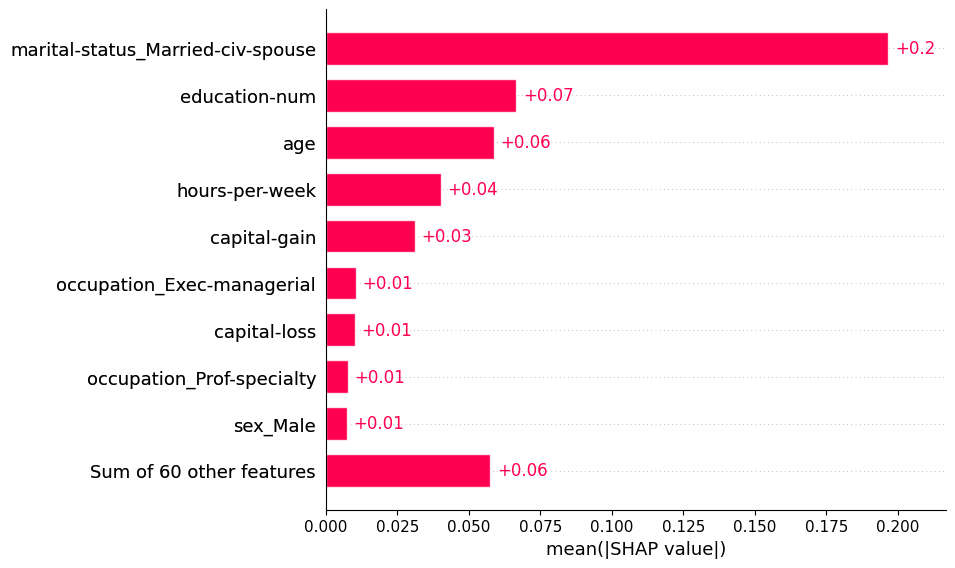

In [120]:
shap.plots.bar(shap_values)

### Partial Dependecy Plots

In [28]:
X_full.columns

Index(['Age', 'Education Level', 'Dollar gain of capital',
       'Dollar loss of capital', 'Working hours per week', 'US Native: (No)',
       'US Native: (Yes)', 'Work Class: Federal Government',
       'Work Class: Local Government', 'Work Class: Never Worked',
       'Work Class: Private', 'Work Class: Self Employed (Incorporated)',
       'Work Class: Self Employed (Not Incorporated)',
       'Work Class: State Government', 'Work Class: Without Pay',
       'Work Class: None', 'Work Class: Not Available',
       'Marital Status: Divorced', 'Marital Status: Married (AF Spouse)',
       'Marital Status: Married (Civilian Spouse)',
       'Marital Status: Married (Spouse Absent)',
       'Marital Status: Never Married', 'Marital Status: Separated',
       'Marital Status: Widowed', 'Occupation: Administrative Clerical',
       'Occupation: Armed Forces', 'Occupation: Craft Repair',
       'Occupation: Executive Managerial', 'Occupation: Farming Fishing',
       'Occupation: Handlers 

In [27]:
# pip install pdpbox
from pdpbox import pdp, info_plots
from sklearn.preprocessing import StandardScaler

# going though examples for team so it won't be complete, but will finish later
X_full_copy = X_full.copy()


# use this to transfrom origianl scaled data
def data_trans(df, scaler=scaler):
    numeric_cols = [
        "Age",
        "Education Level",
        "Dollar gain of capital",
        "Dollar loss of capital",
        "Working hours per week",
    ]
    df[numeric_cols] = scaler.transform(df[numeric_cols])
    return df


# numerical feature
pdp_age = pdp.PDPIsolate(
    model=catboost_final,
    df=X_full_copy,
    model_features=X_full_copy.columns,
    feature="Age",
    feature_name="Age",
    data_transformer=data_trans,
    n_classes=2,
)

# "age" is scaled so this will cause issues, will talk to Babara about this
# scaling the data isn't feasible
# when you scale your data, the original meaning of the features may become less directly interpretable

fig, axes = pdp_age.plot(
    center=True,
    frac_to_plot=100,
    cluster=False,
    n_cluster_centers=None,
    cluster_method="accurate",
    to_bins=False,
    show_percentile=True,
    which_classes=None,
    figsize=None,
    dpi=300,
    ncols=2,
    plot_params=None,
    engine="matplotlib",
    template="plotly_white",
)
plt.show()

obtain pred_func from the provided model.


  0%|          | 0/10 [00:00<?, ?it/s]

KeyError: "None of [Index(['age', 'education-num', 'capital-gain', 'capital-loss',\n       'hours-per-week'],\n      dtype='object')] are in the [columns]"

In [124]:
# group them together
marrige_columns = [col for col in X_full.columns if col.startswith("marital-status_")]

obtain pred_func from the provided model.


  0%|          | 0/7 [00:00<?, ?it/s]

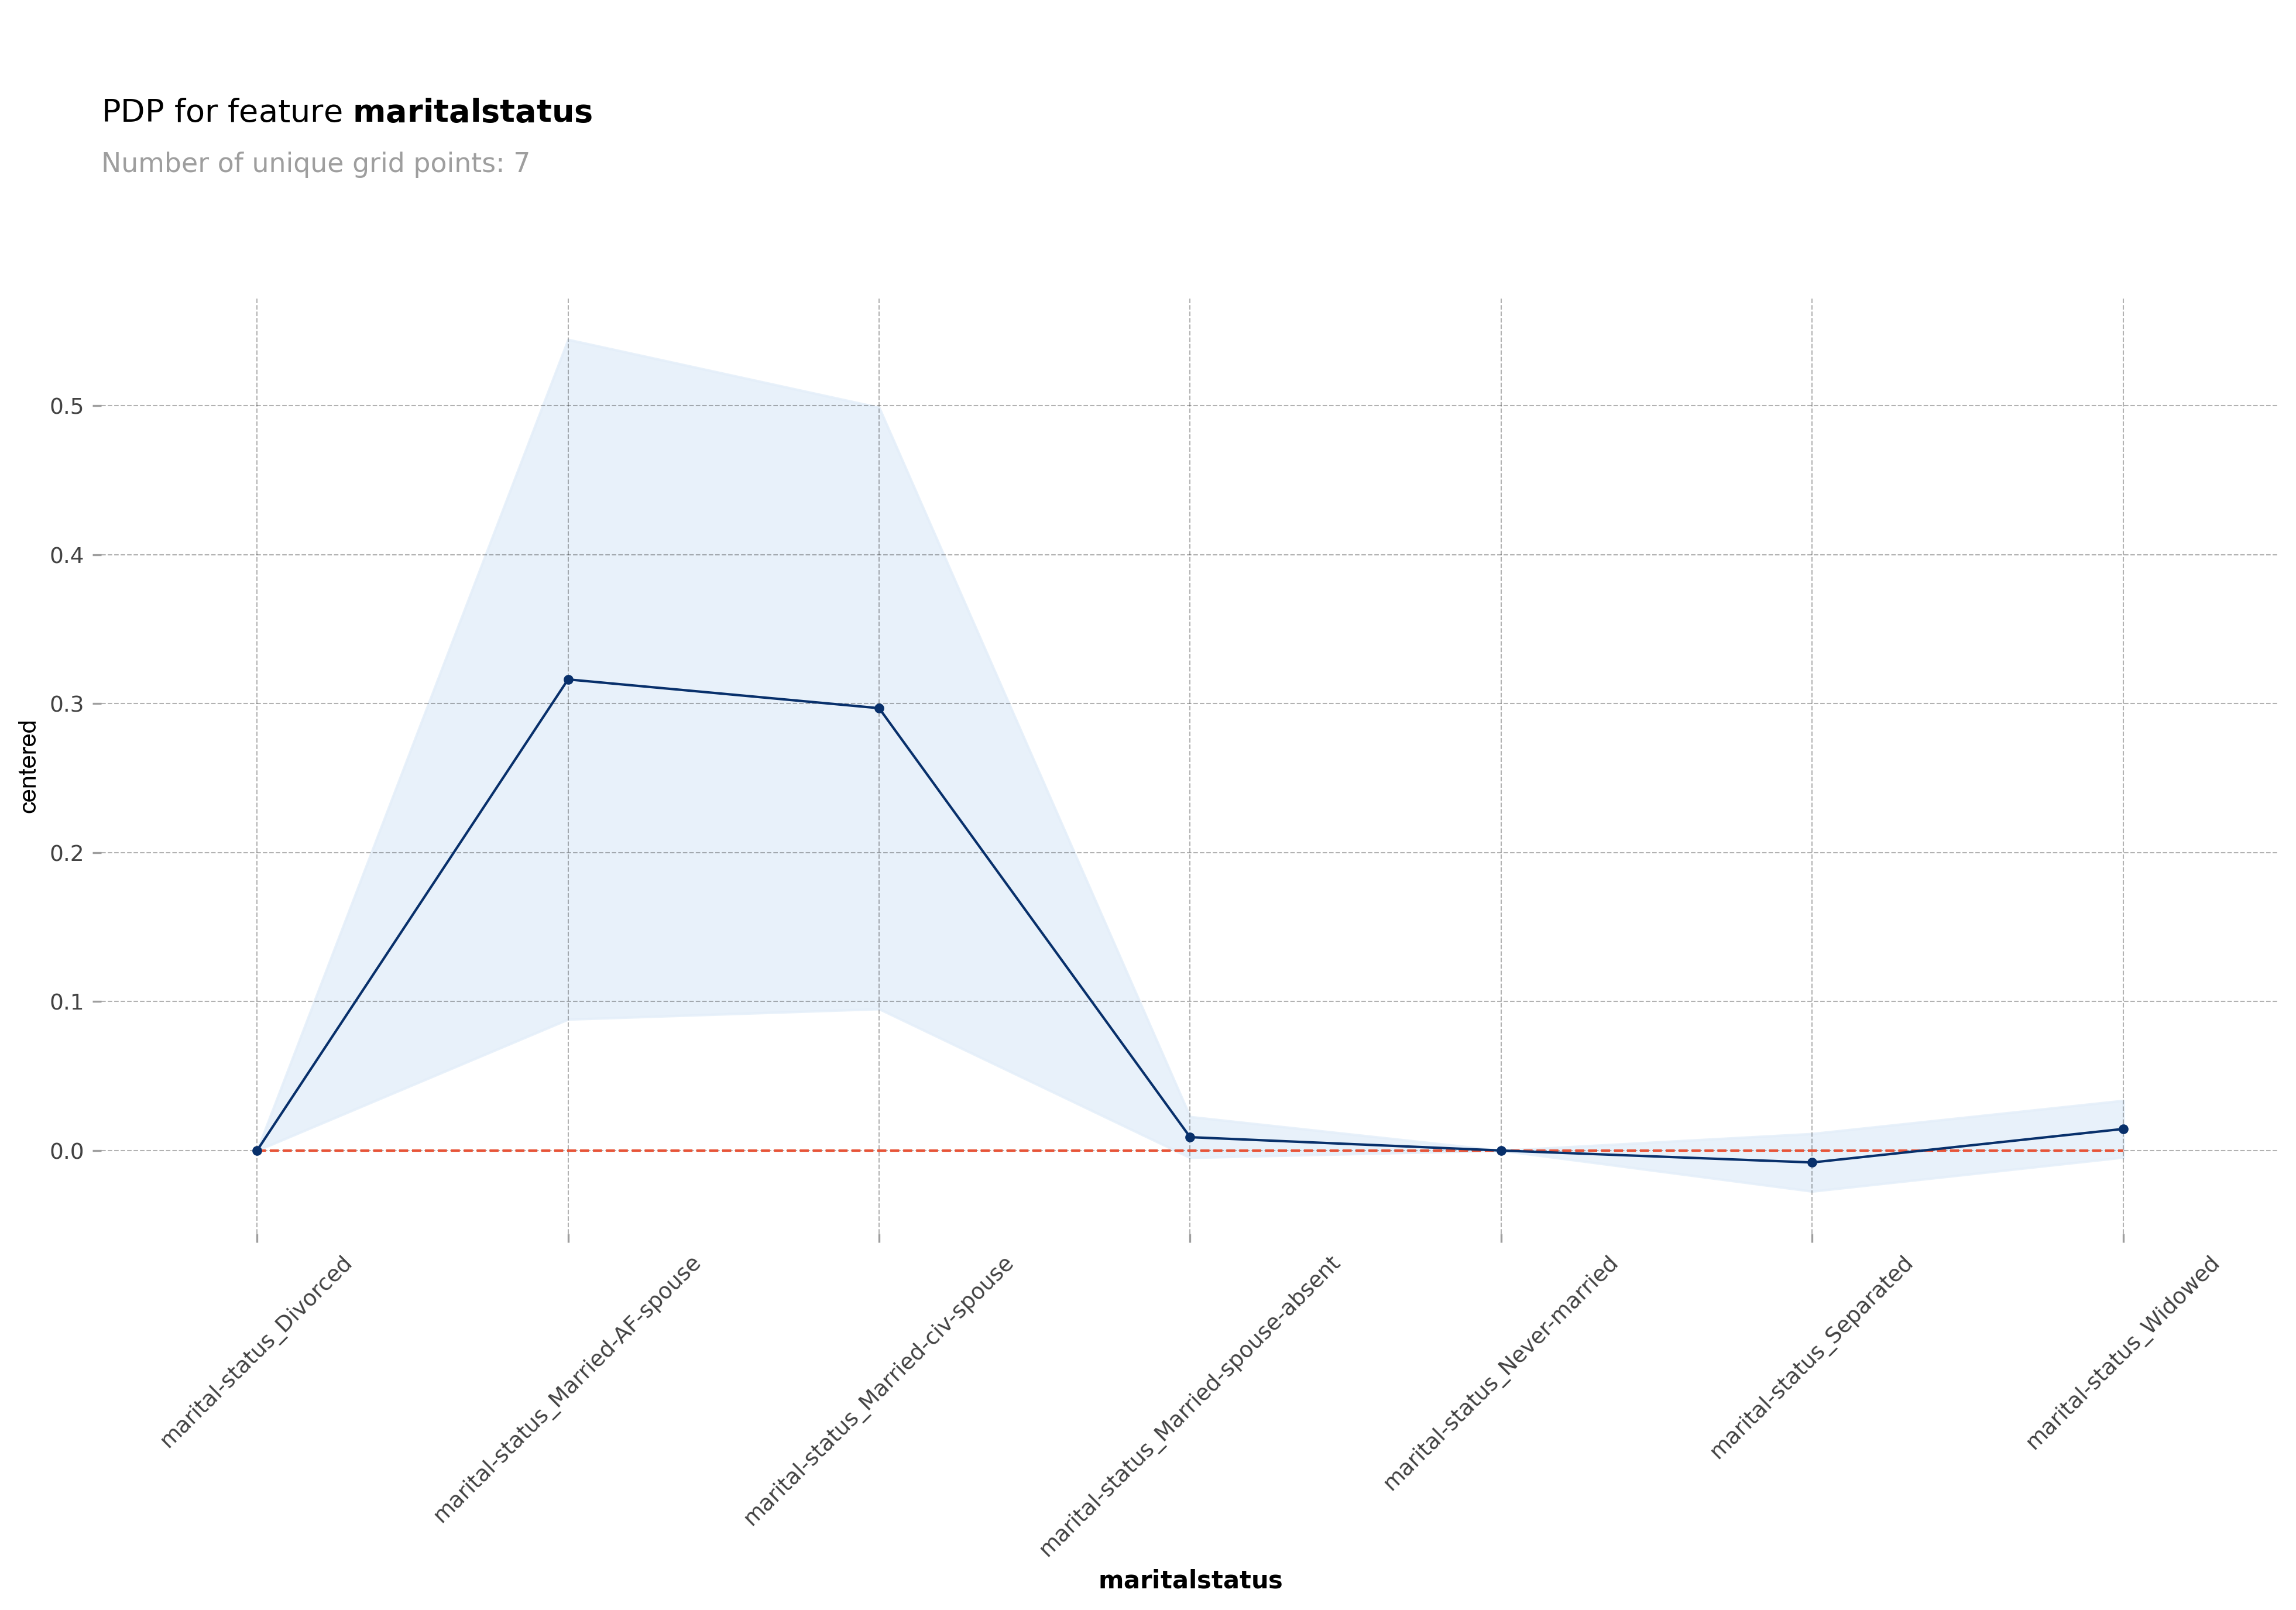

In [125]:
# categorical feature
X_full_copy = X_full.copy()

pdp_married = pdp.PDPIsolate(
    model=catboost_final,
    df=X_full_copy,
    model_features=X_full_copy.columns,
    feature=marrige_columns,
    feature_name="marital status",
    data_transformer=data_trans,
    n_classes=2,
)

fig, axes = pdp_married.plot(
    center=True,
    frac_to_plot=100,
    cluster=False,
    n_cluster_centers=None,
    cluster_method="accurate",
    to_bins=False,
    show_percentile=True,
    which_classes=None,
    figsize=None,
    dpi=300,
    ncols=2,
    plot_params=None,
    engine="matplotlib",
    template="plotly_white",
)
plt.xticks(rotation=45)

# Show the plot
plt.show()

obtain pred_func from the provided model.


  0%|          | 0/6 [00:00<?, ?it/s]

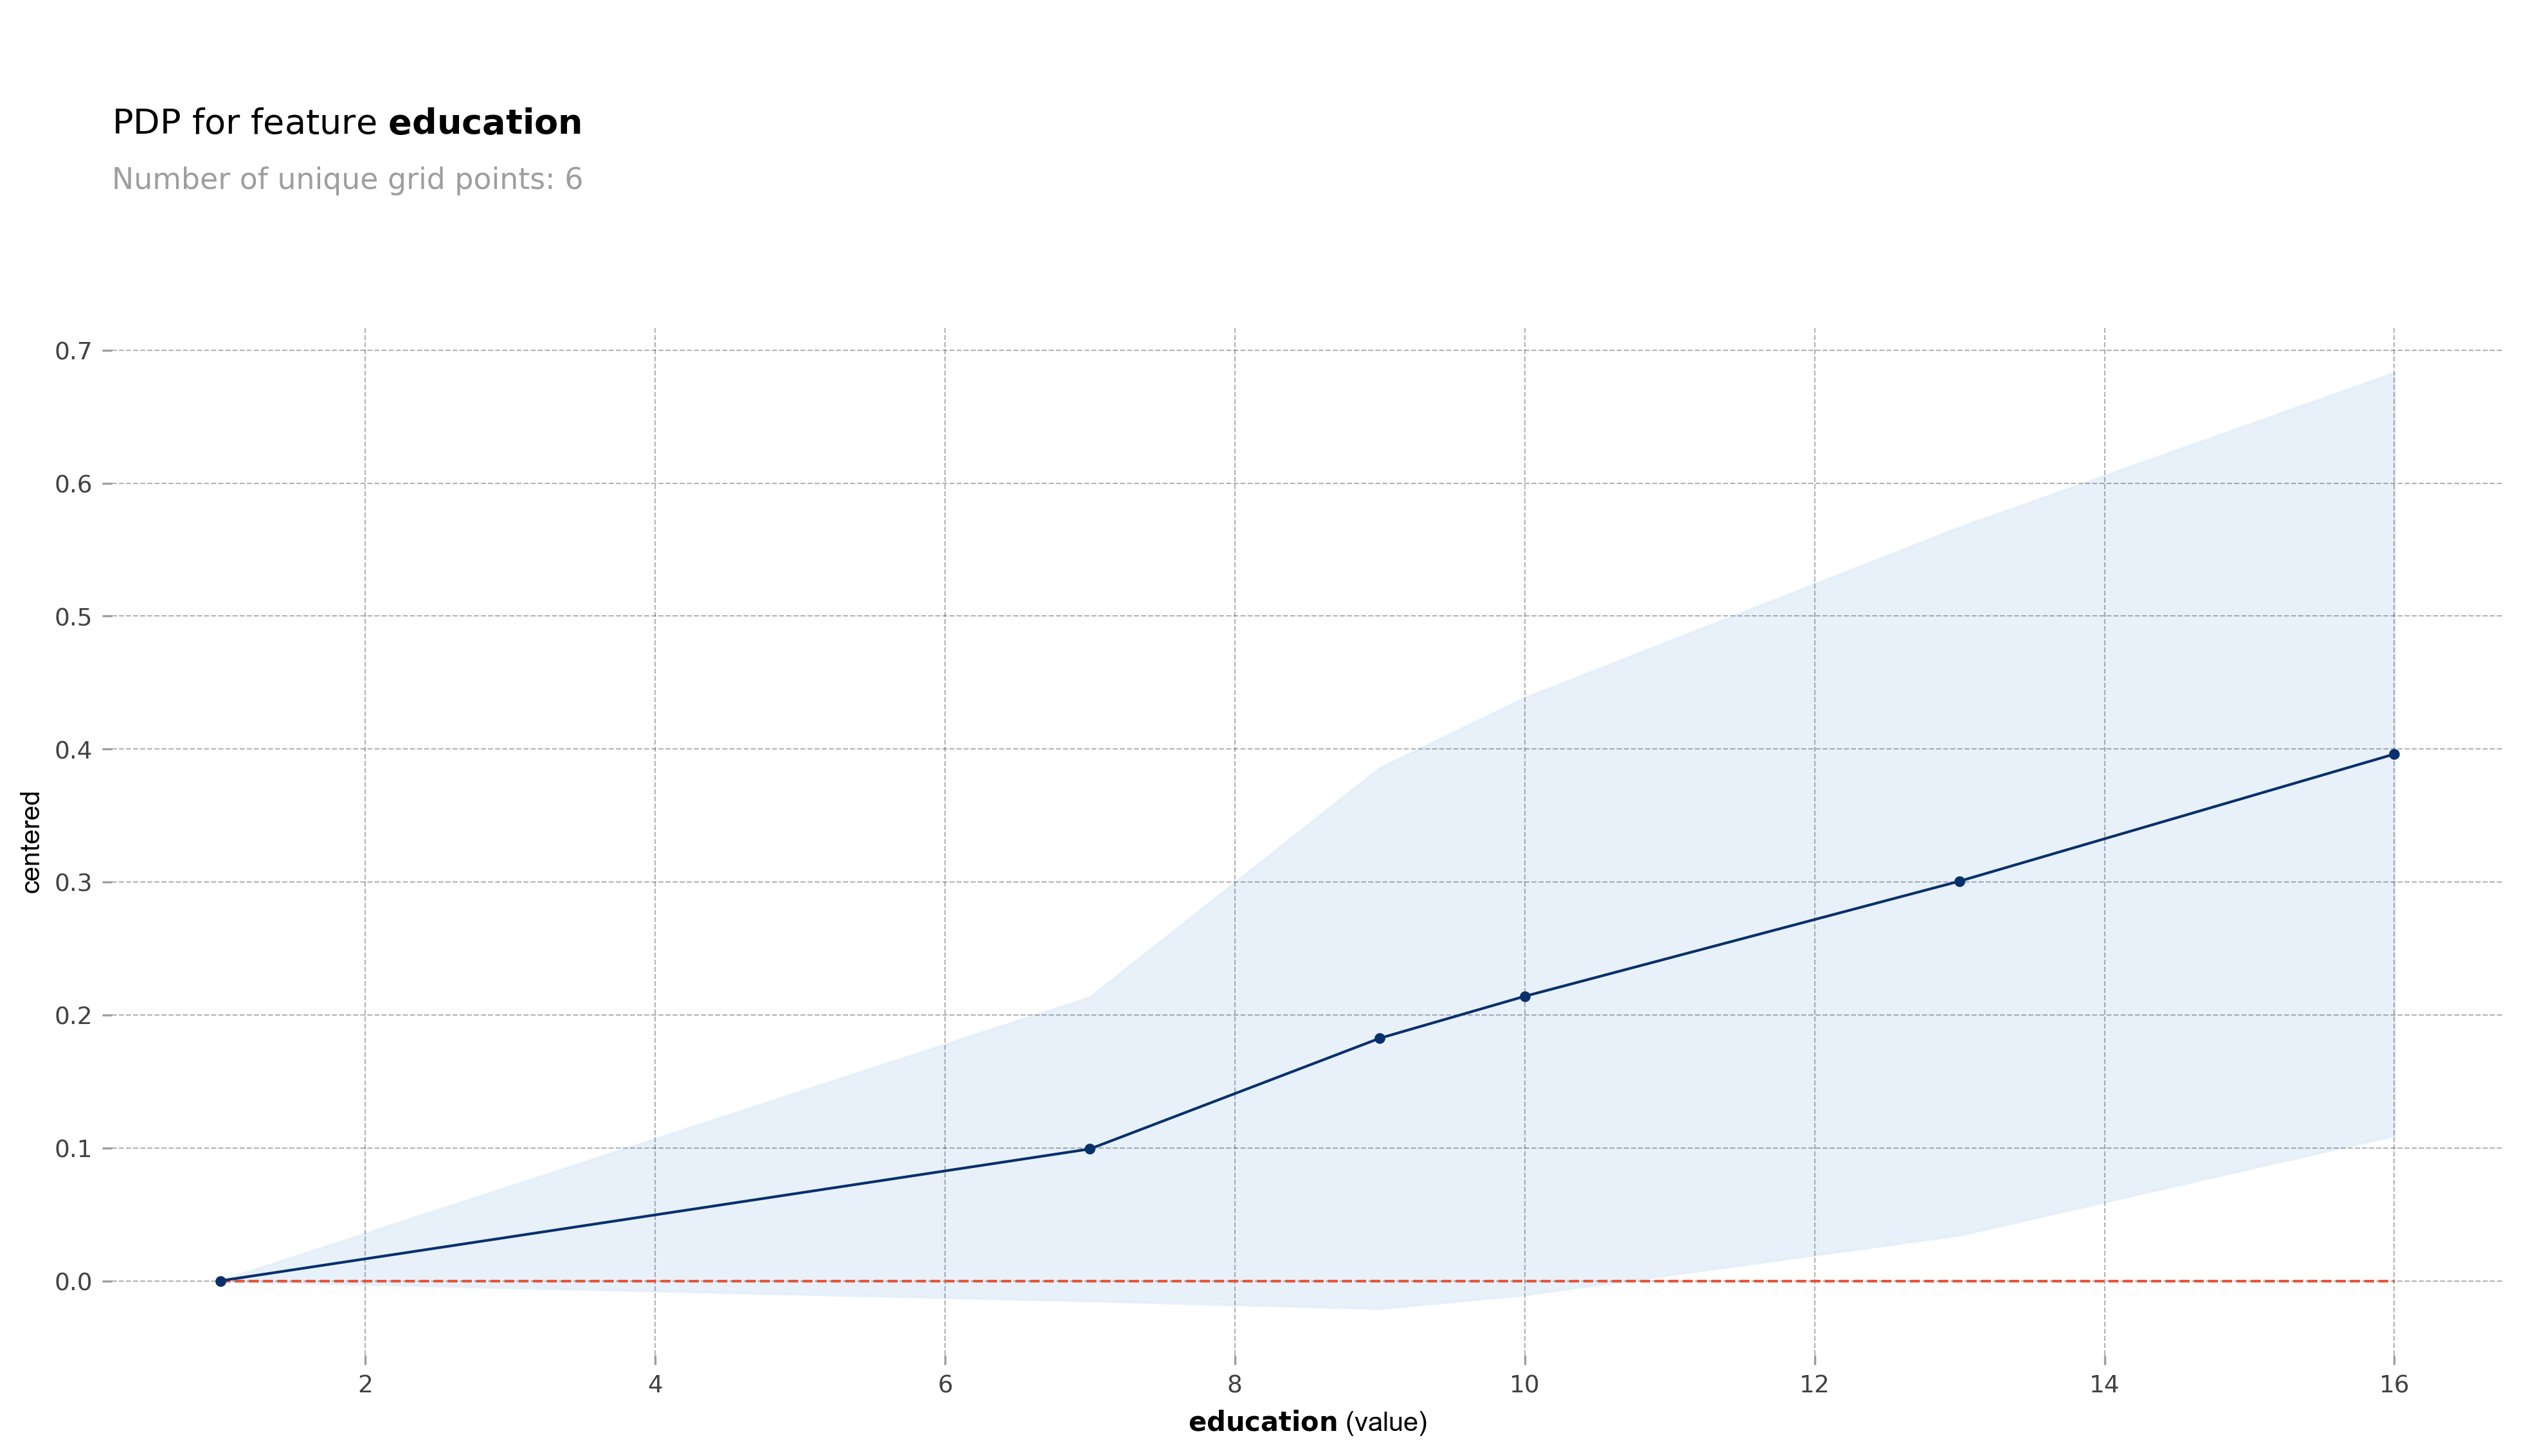

In [126]:
# education level
X_full_copy = X_full.copy()

pdp_education = pdp.PDPIsolate(
    model=catboost_final,
    df=X_full_copy,
    model_features=X_full_copy.columns,
    feature="education-num",
    feature_name="education",
    data_transformer=data_trans,
    n_classes=2,
)

fig, axes = pdp_education.plot(
    center=True,
    frac_to_plot=100,
    cluster=False,
    n_cluster_centers=None,
    cluster_method="accurate",
    to_bins=False,
    show_percentile=True,
    which_classes=None,
    figsize=None,
    dpi=300,
    ncols=2,
    plot_params=None,
    engine="matplotlib",
    template="plotly_white",
)
# Show the plot
plt.show()

obtain pred_func from the provided model.


  0%|          | 0/7 [00:00<?, ?it/s]

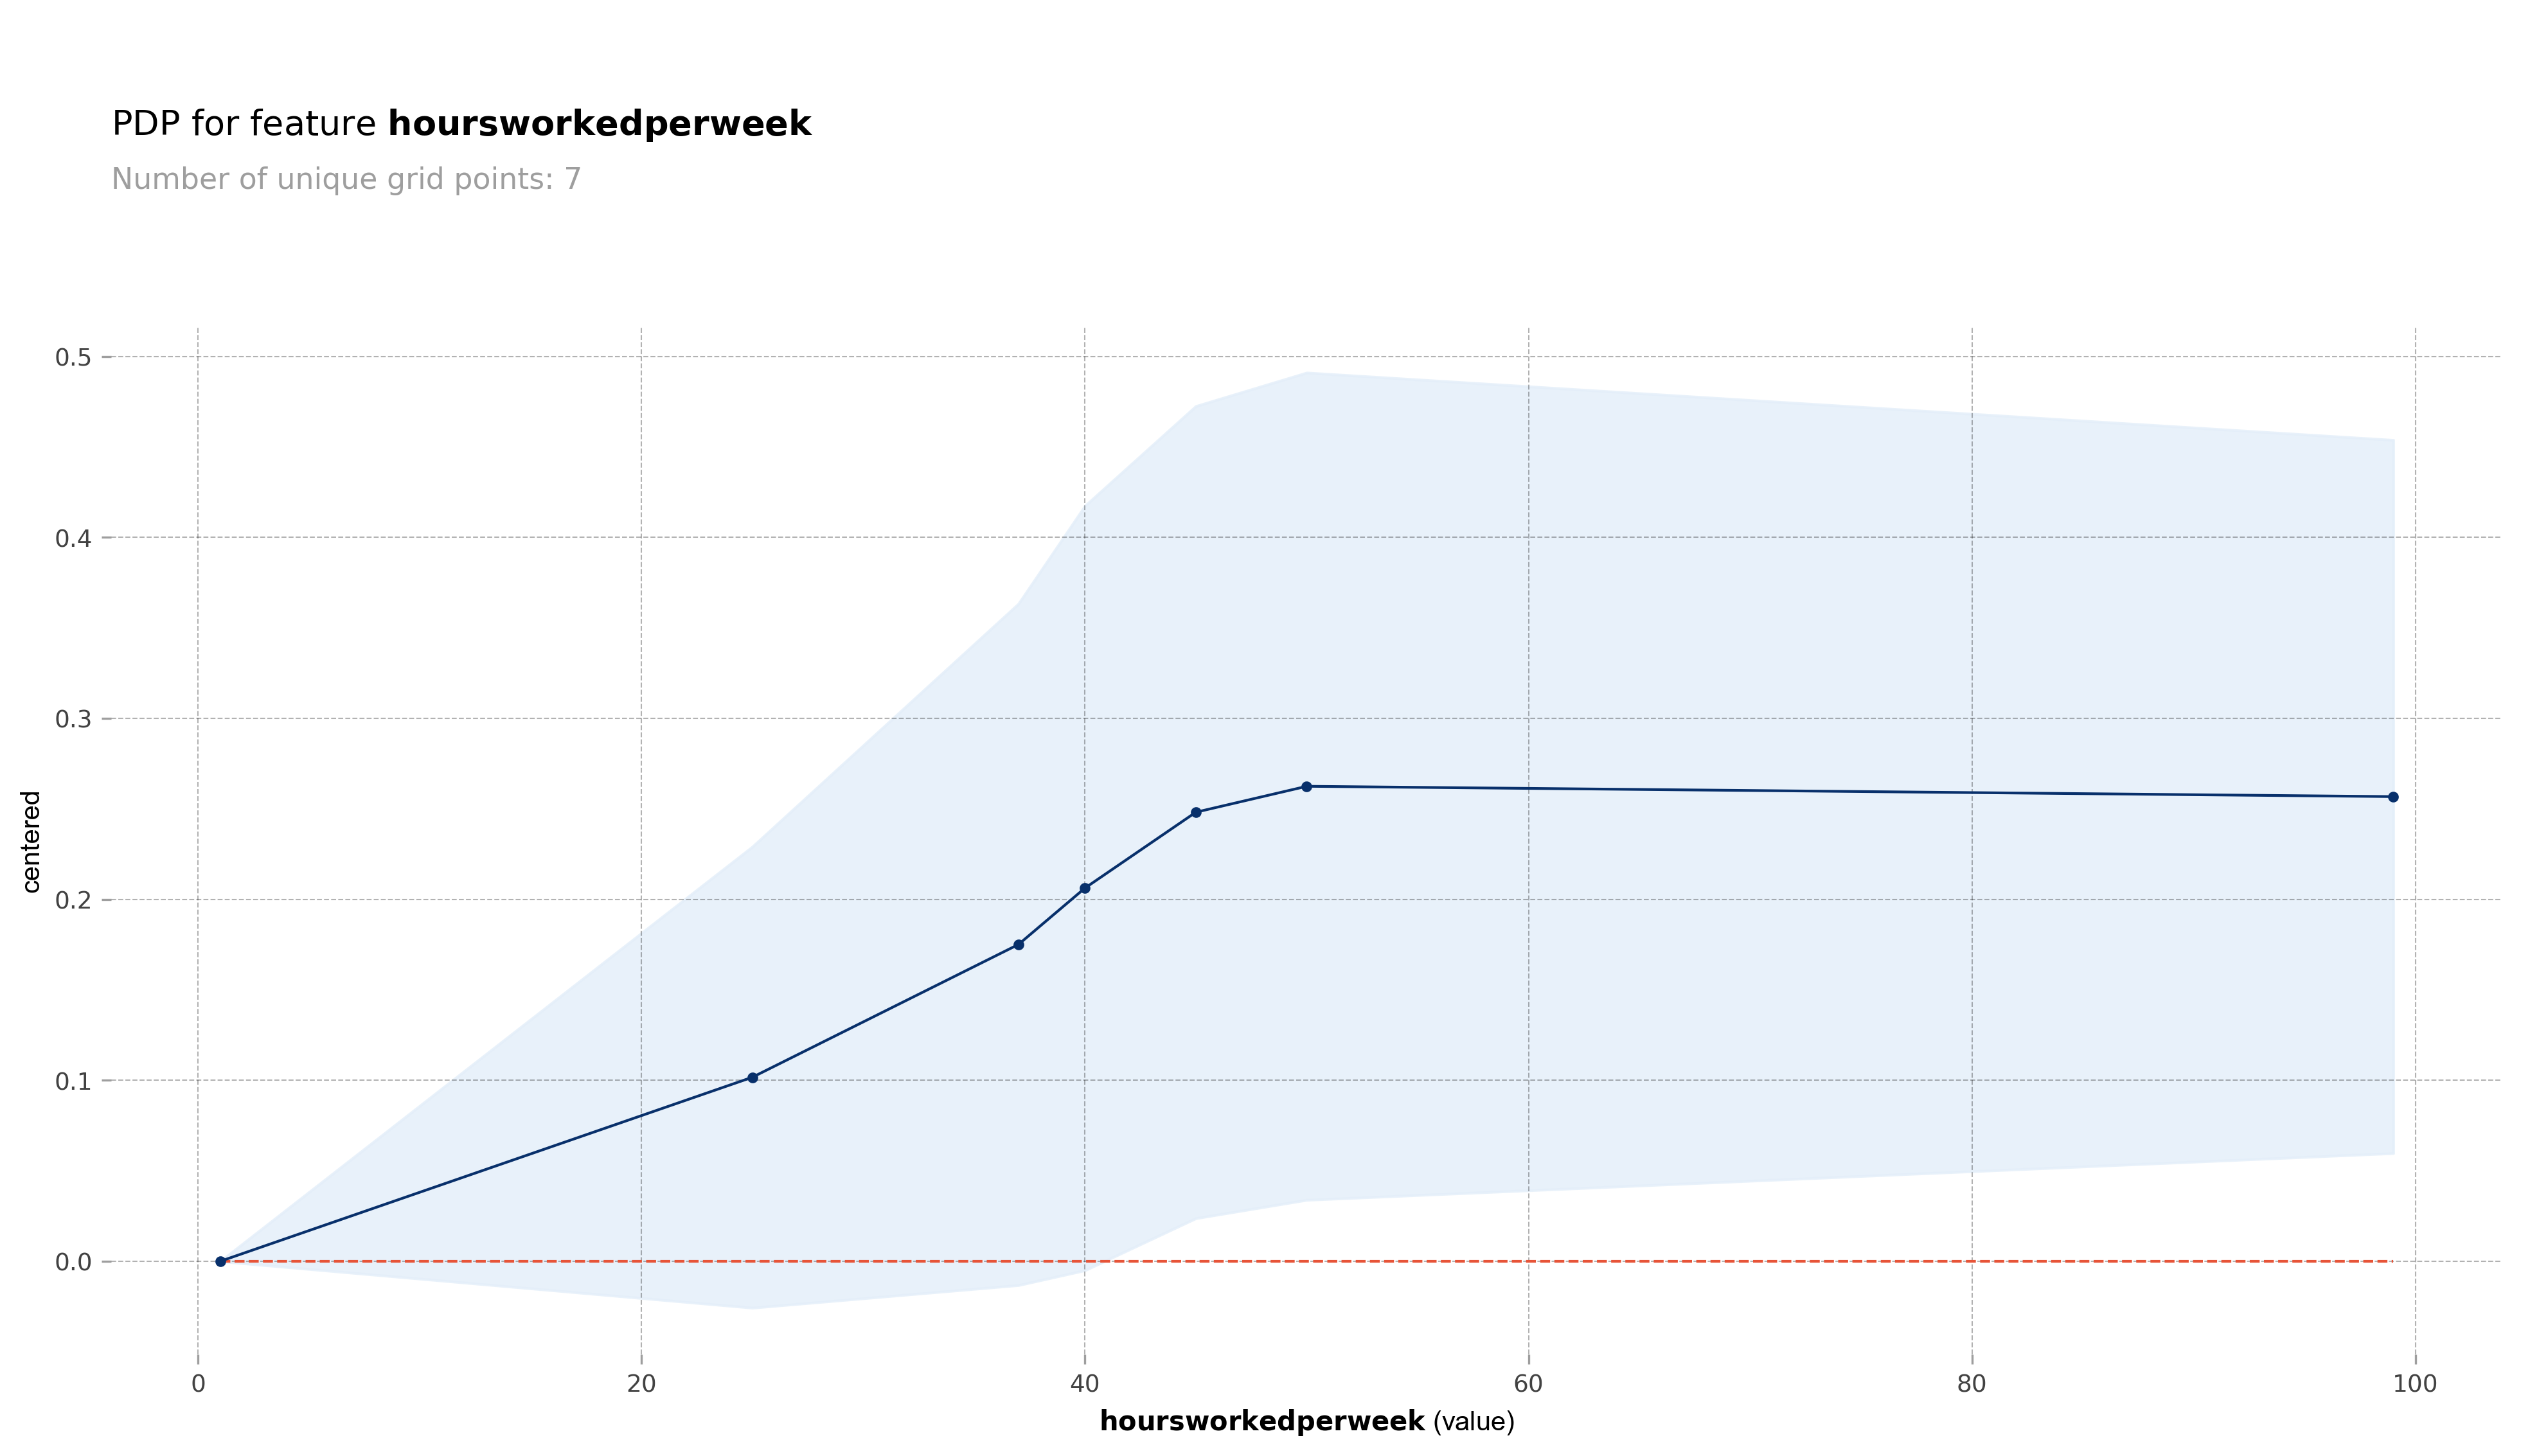

In [127]:
# hours-per-week
X_full_copy = X_full.copy()

pdp_hours = pdp.PDPIsolate(
    model=catboost_final,
    df=X_full_copy,
    model_features=X_full_copy.columns,
    feature="hours-per-week",
    feature_name="hoursworkedperweek",
    data_transformer=data_trans,
    n_classes=2,
)

fig, axes = pdp_hours.plot(
    center=True,
    frac_to_plot=100,
    cluster=False,
    n_cluster_centers=None,
    cluster_method="accurate",
    to_bins=False,
    show_percentile=True,
    which_classes=None,
    figsize=None,
    dpi=300,
    ncols=2,
    plot_params=None,
    engine="matplotlib",
    template="plotly_white",
)
# Show the plot
plt.show()

obtain pred_func from the provided model.


  0%|          | 0/2 [00:00<?, ?it/s]

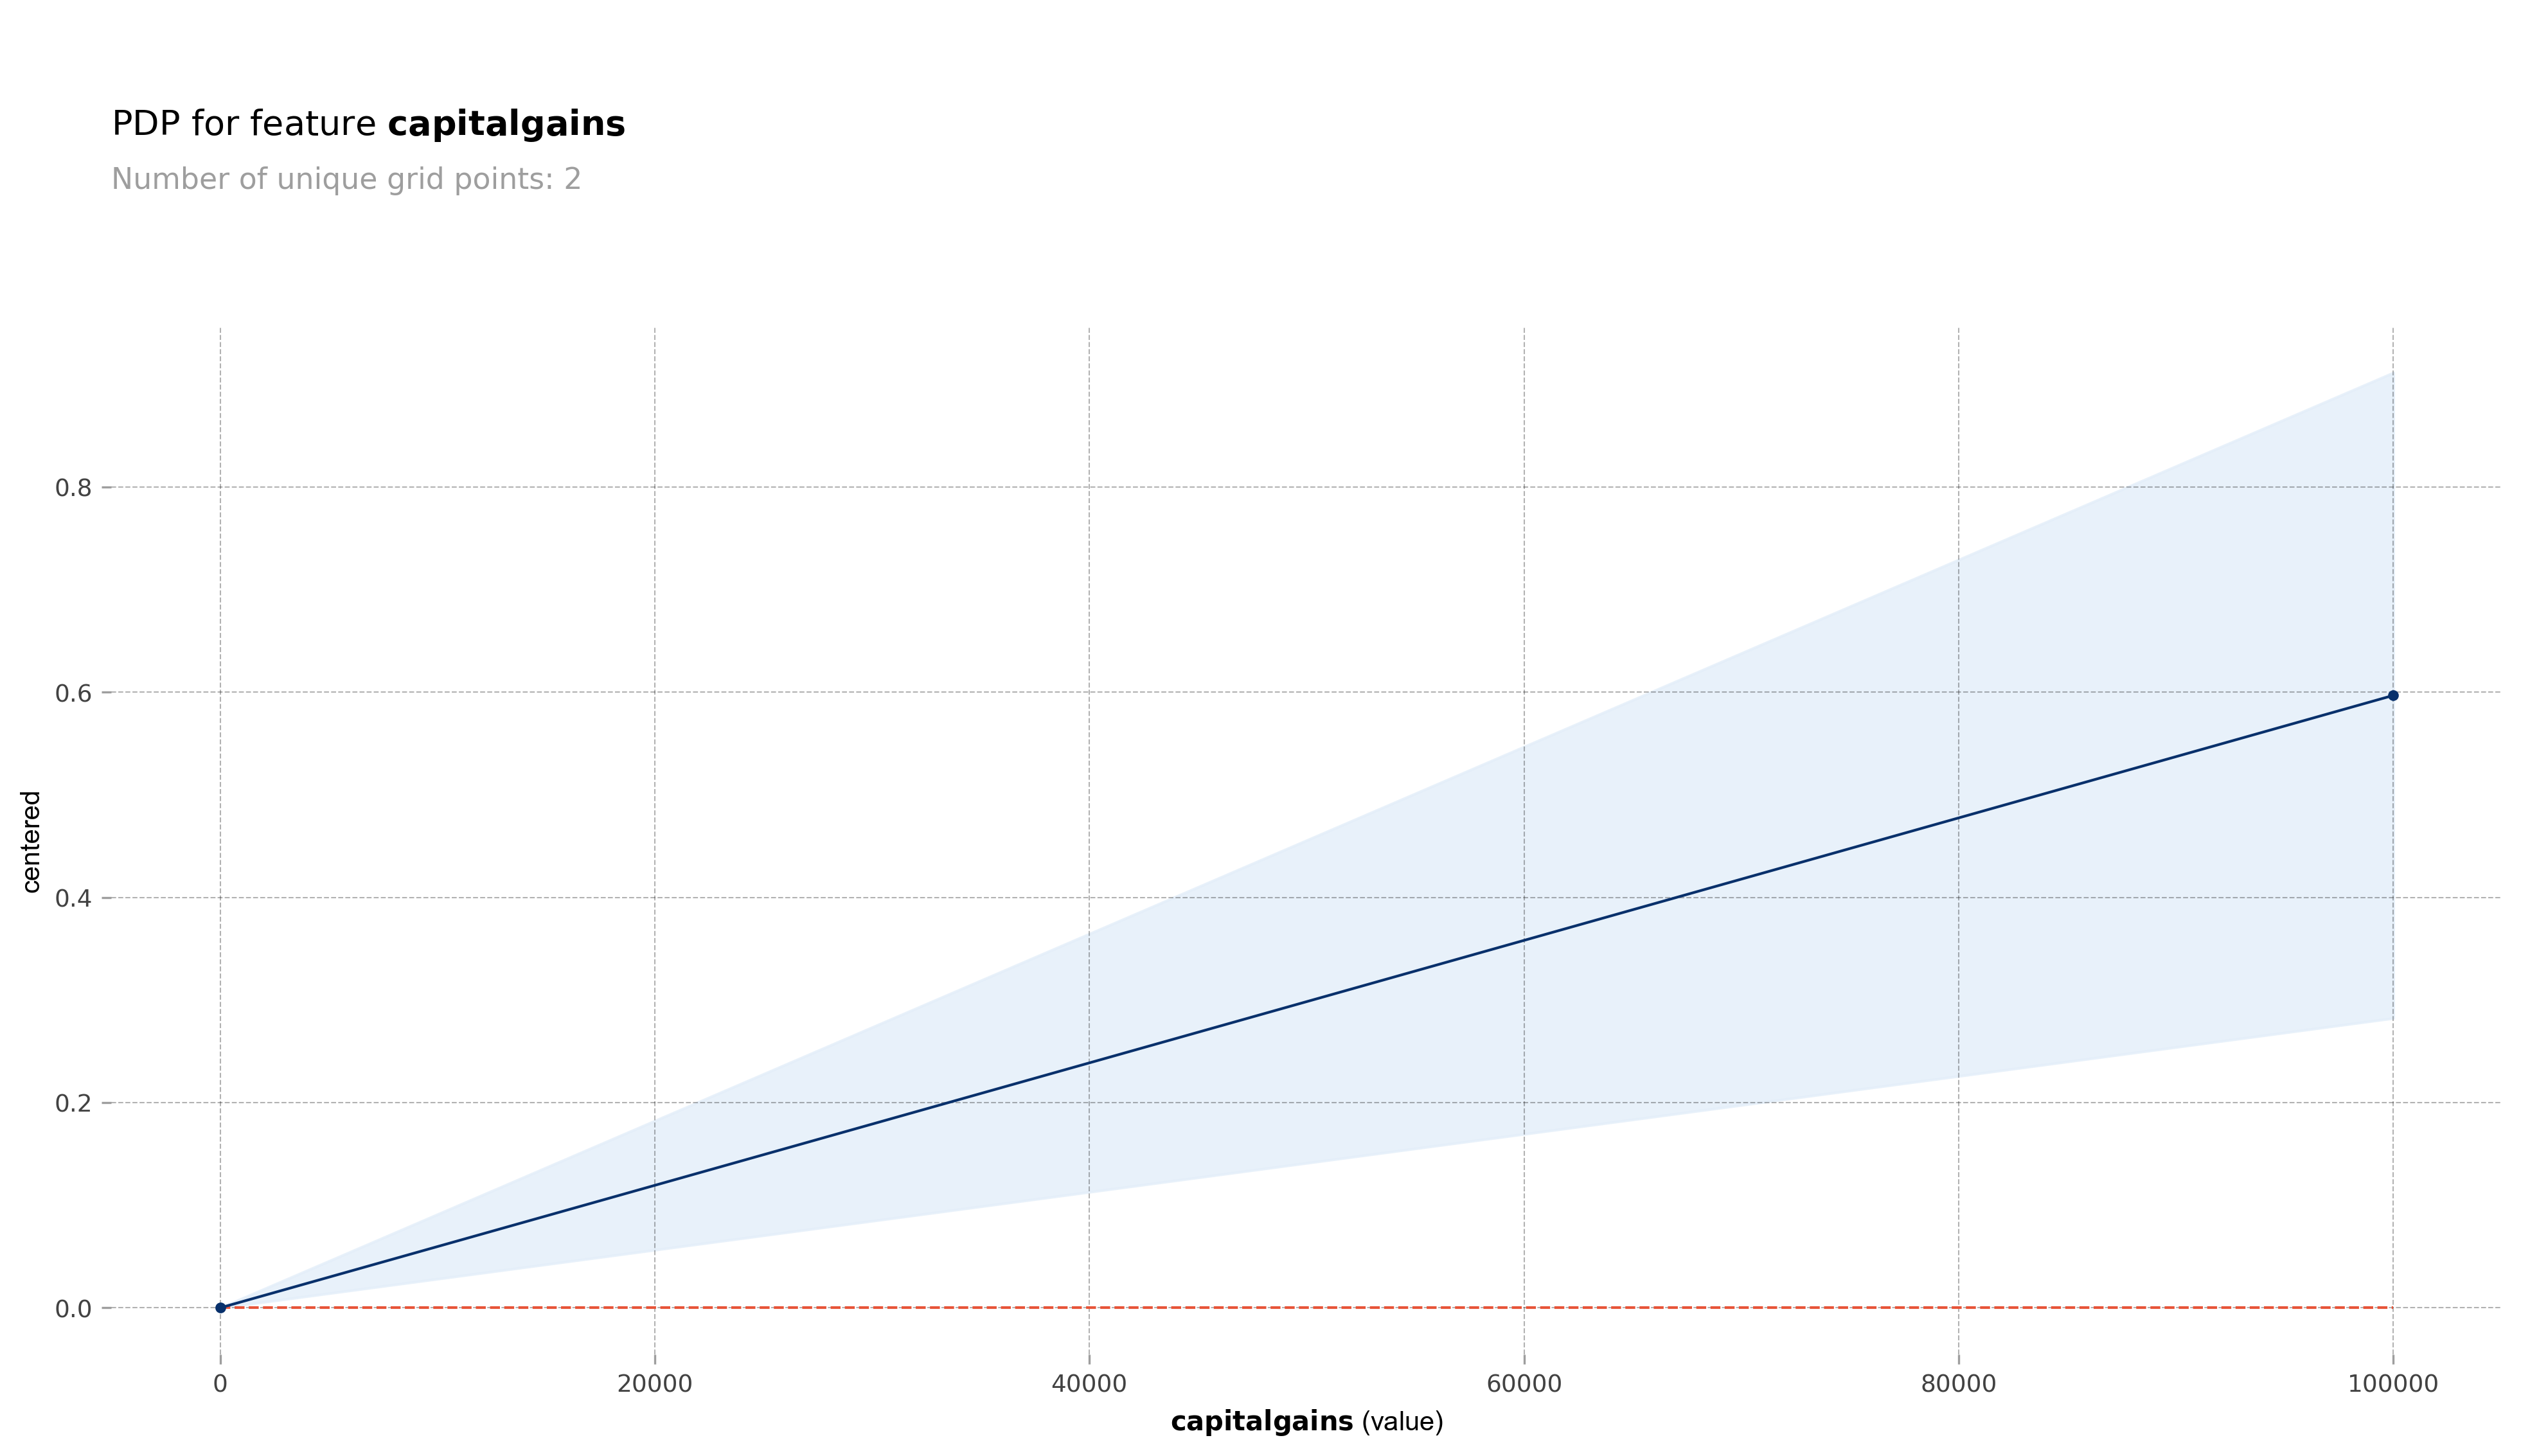

In [128]:
# captial gains
X_full_copy = X_full.copy()

pdp_cp = pdp.PDPIsolate(
    model=catboost_final,
    df=X_full_copy,
    model_features=X_full_copy.columns,
    feature="capital-gain",
    feature_name="capital gains",
    data_transformer=data_trans,
    n_classes=2,
)

fig, axes = pdp_cp.plot(
    center=True,
    frac_to_plot=100,
    cluster=False,
    n_cluster_centers=None,
    cluster_method="accurate",
    to_bins=False,
    show_percentile=True,
    which_classes=None,
    figsize=None,
    dpi=300,
    ncols=2,
    plot_params=None,
    engine="matplotlib",
    template="plotly_white",
)
# Show the plot
plt.show()

obtain pred_func from the provided model.


  0%|          | 0/16 [00:00<?, ?it/s]

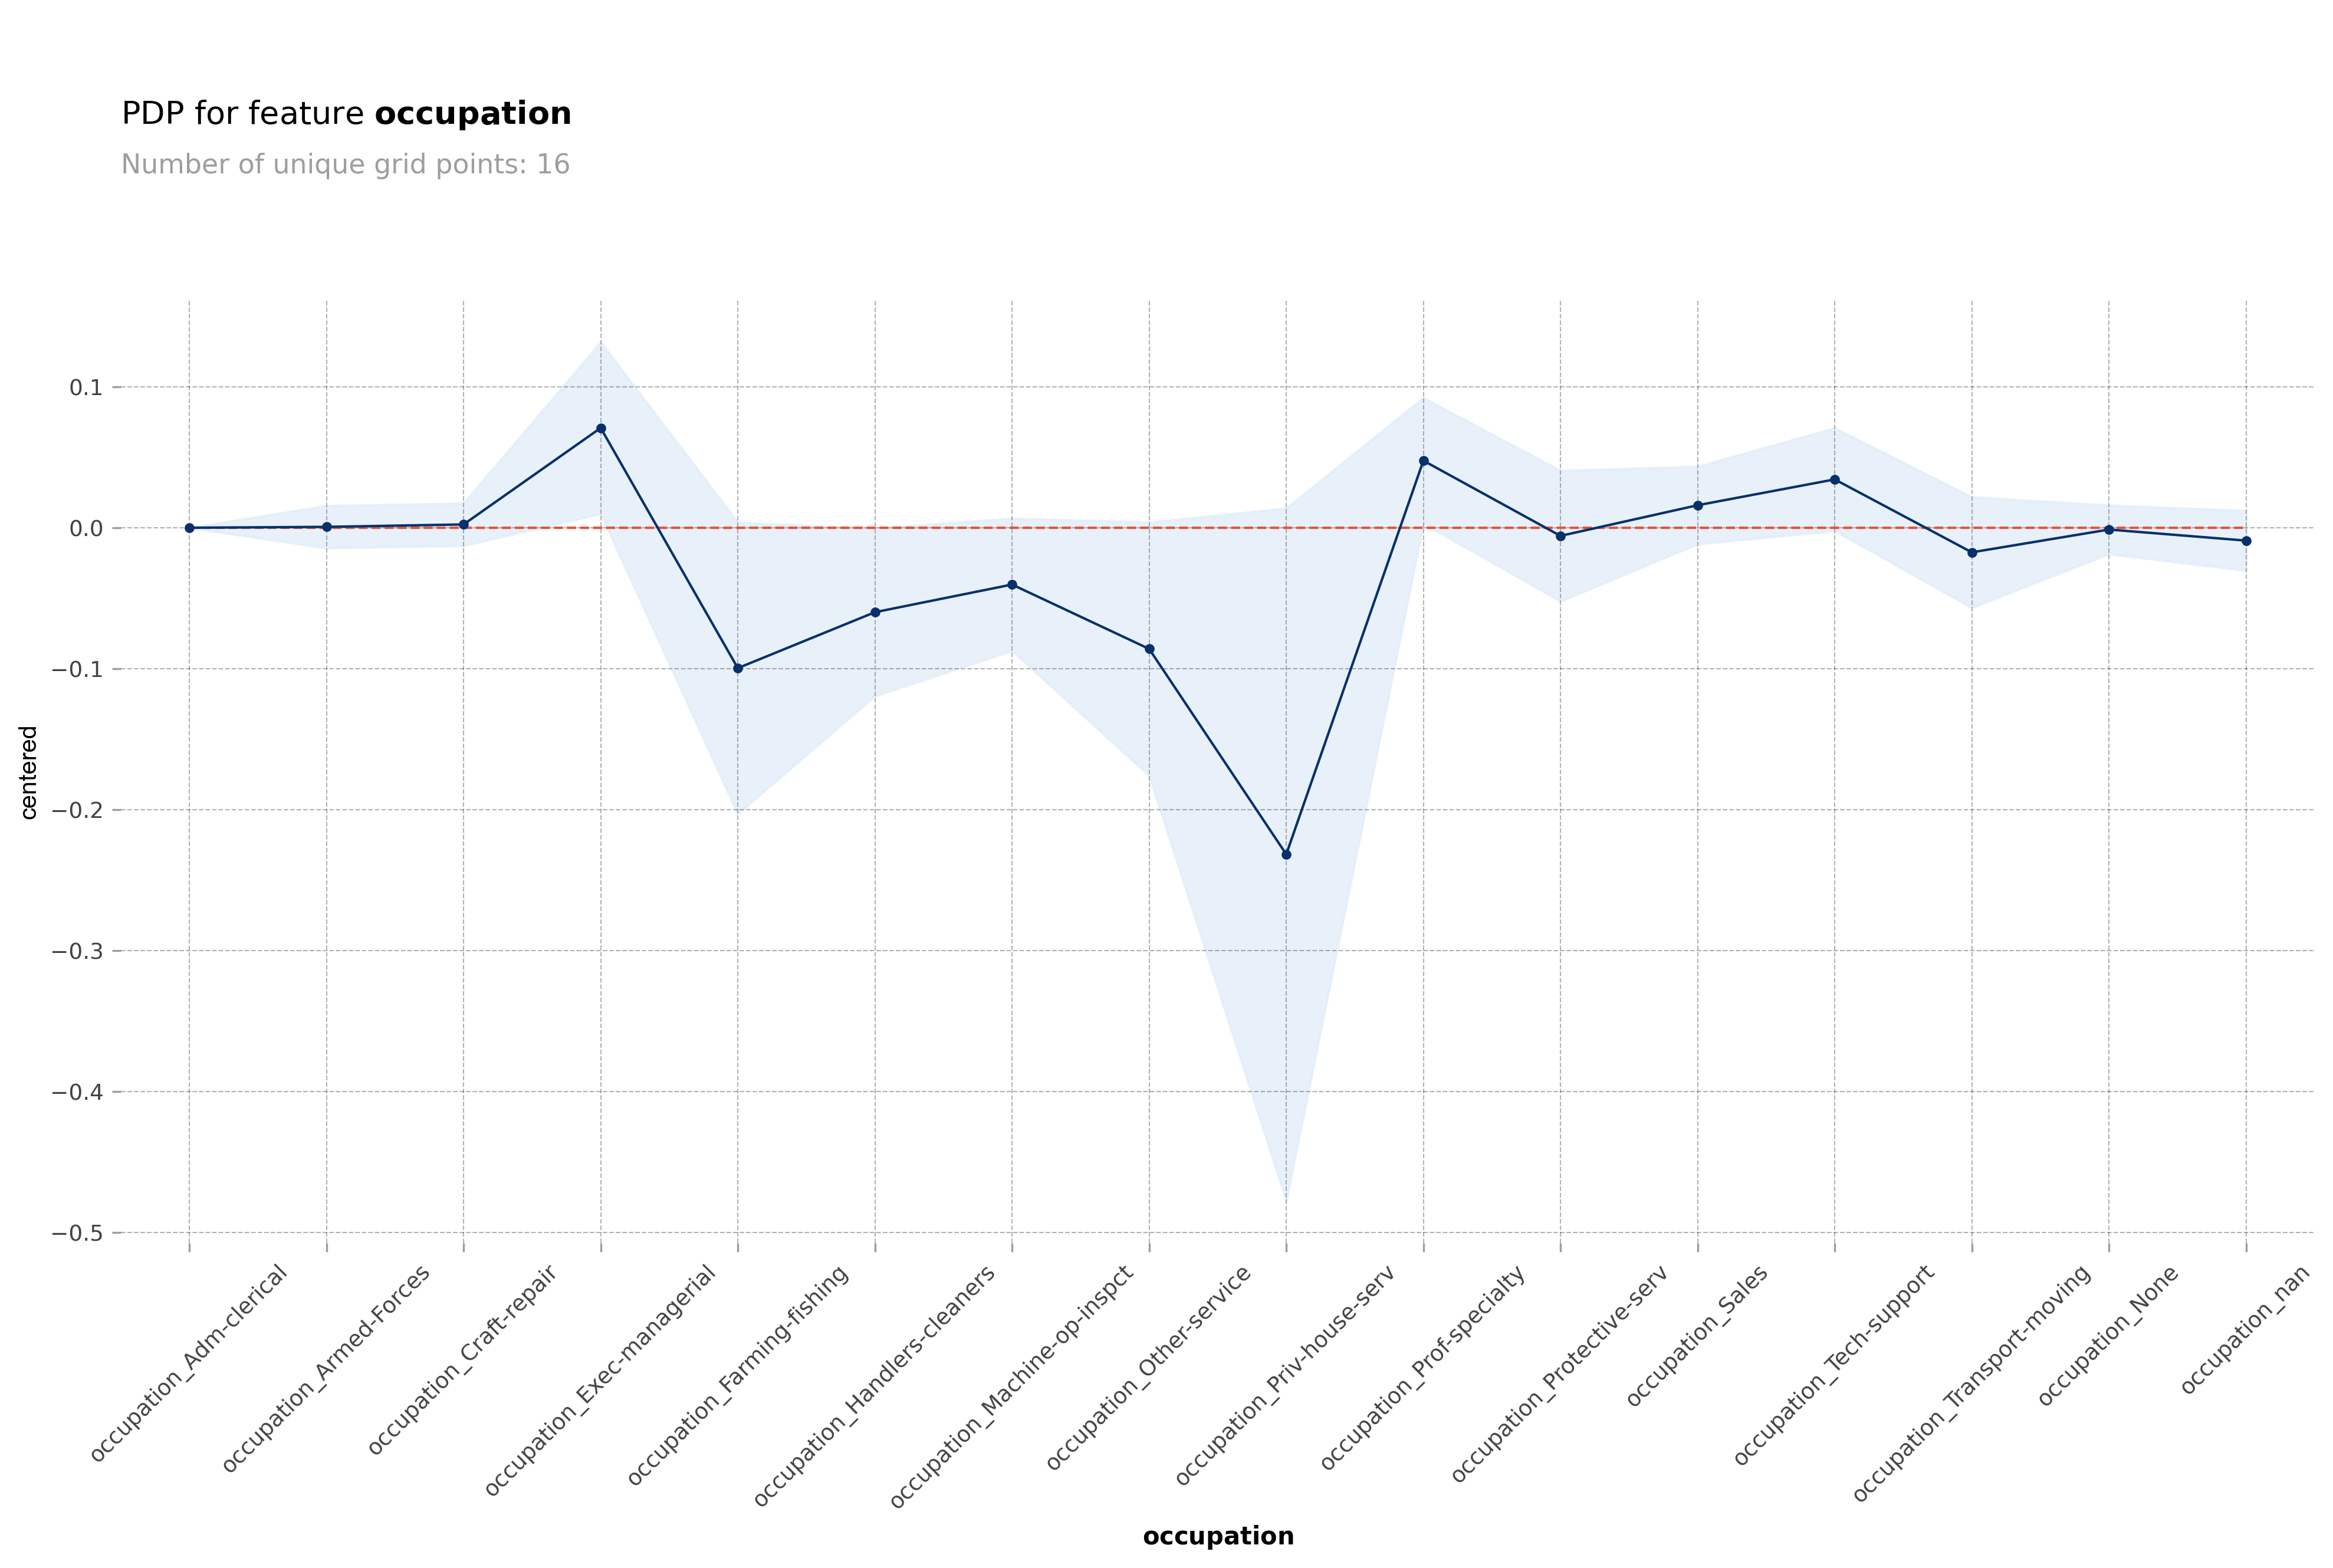

In [129]:
# occupation categorical
occup_columns = [col for col in X_full.columns if col.startswith("occupation_")]


# categorical feature
X_full_copy = X_full.copy()

pdp_occup = pdp.PDPIsolate(
    model=catboost_final,
    df=X_full_copy,
    model_features=X_full_copy.columns,
    feature=occup_columns,
    feature_name="occupation",
    data_transformer=data_trans,
    n_classes=2,
)

fig, axes = pdp_occup.plot(
    center=True,
    frac_to_plot=100,
    cluster=False,
    n_cluster_centers=None,
    cluster_method="accurate",
    to_bins=False,
    show_percentile=True,
    which_classes=None,
    figsize=None,
    dpi=300,
    ncols=2,
    plot_params=None,
    engine="matplotlib",
    template="plotly_white",
)
plt.xticks(rotation=45)

plt.show()

obtain pred_func from the provided model.


  0%|          | 0/6 [00:00<?, ?it/s]

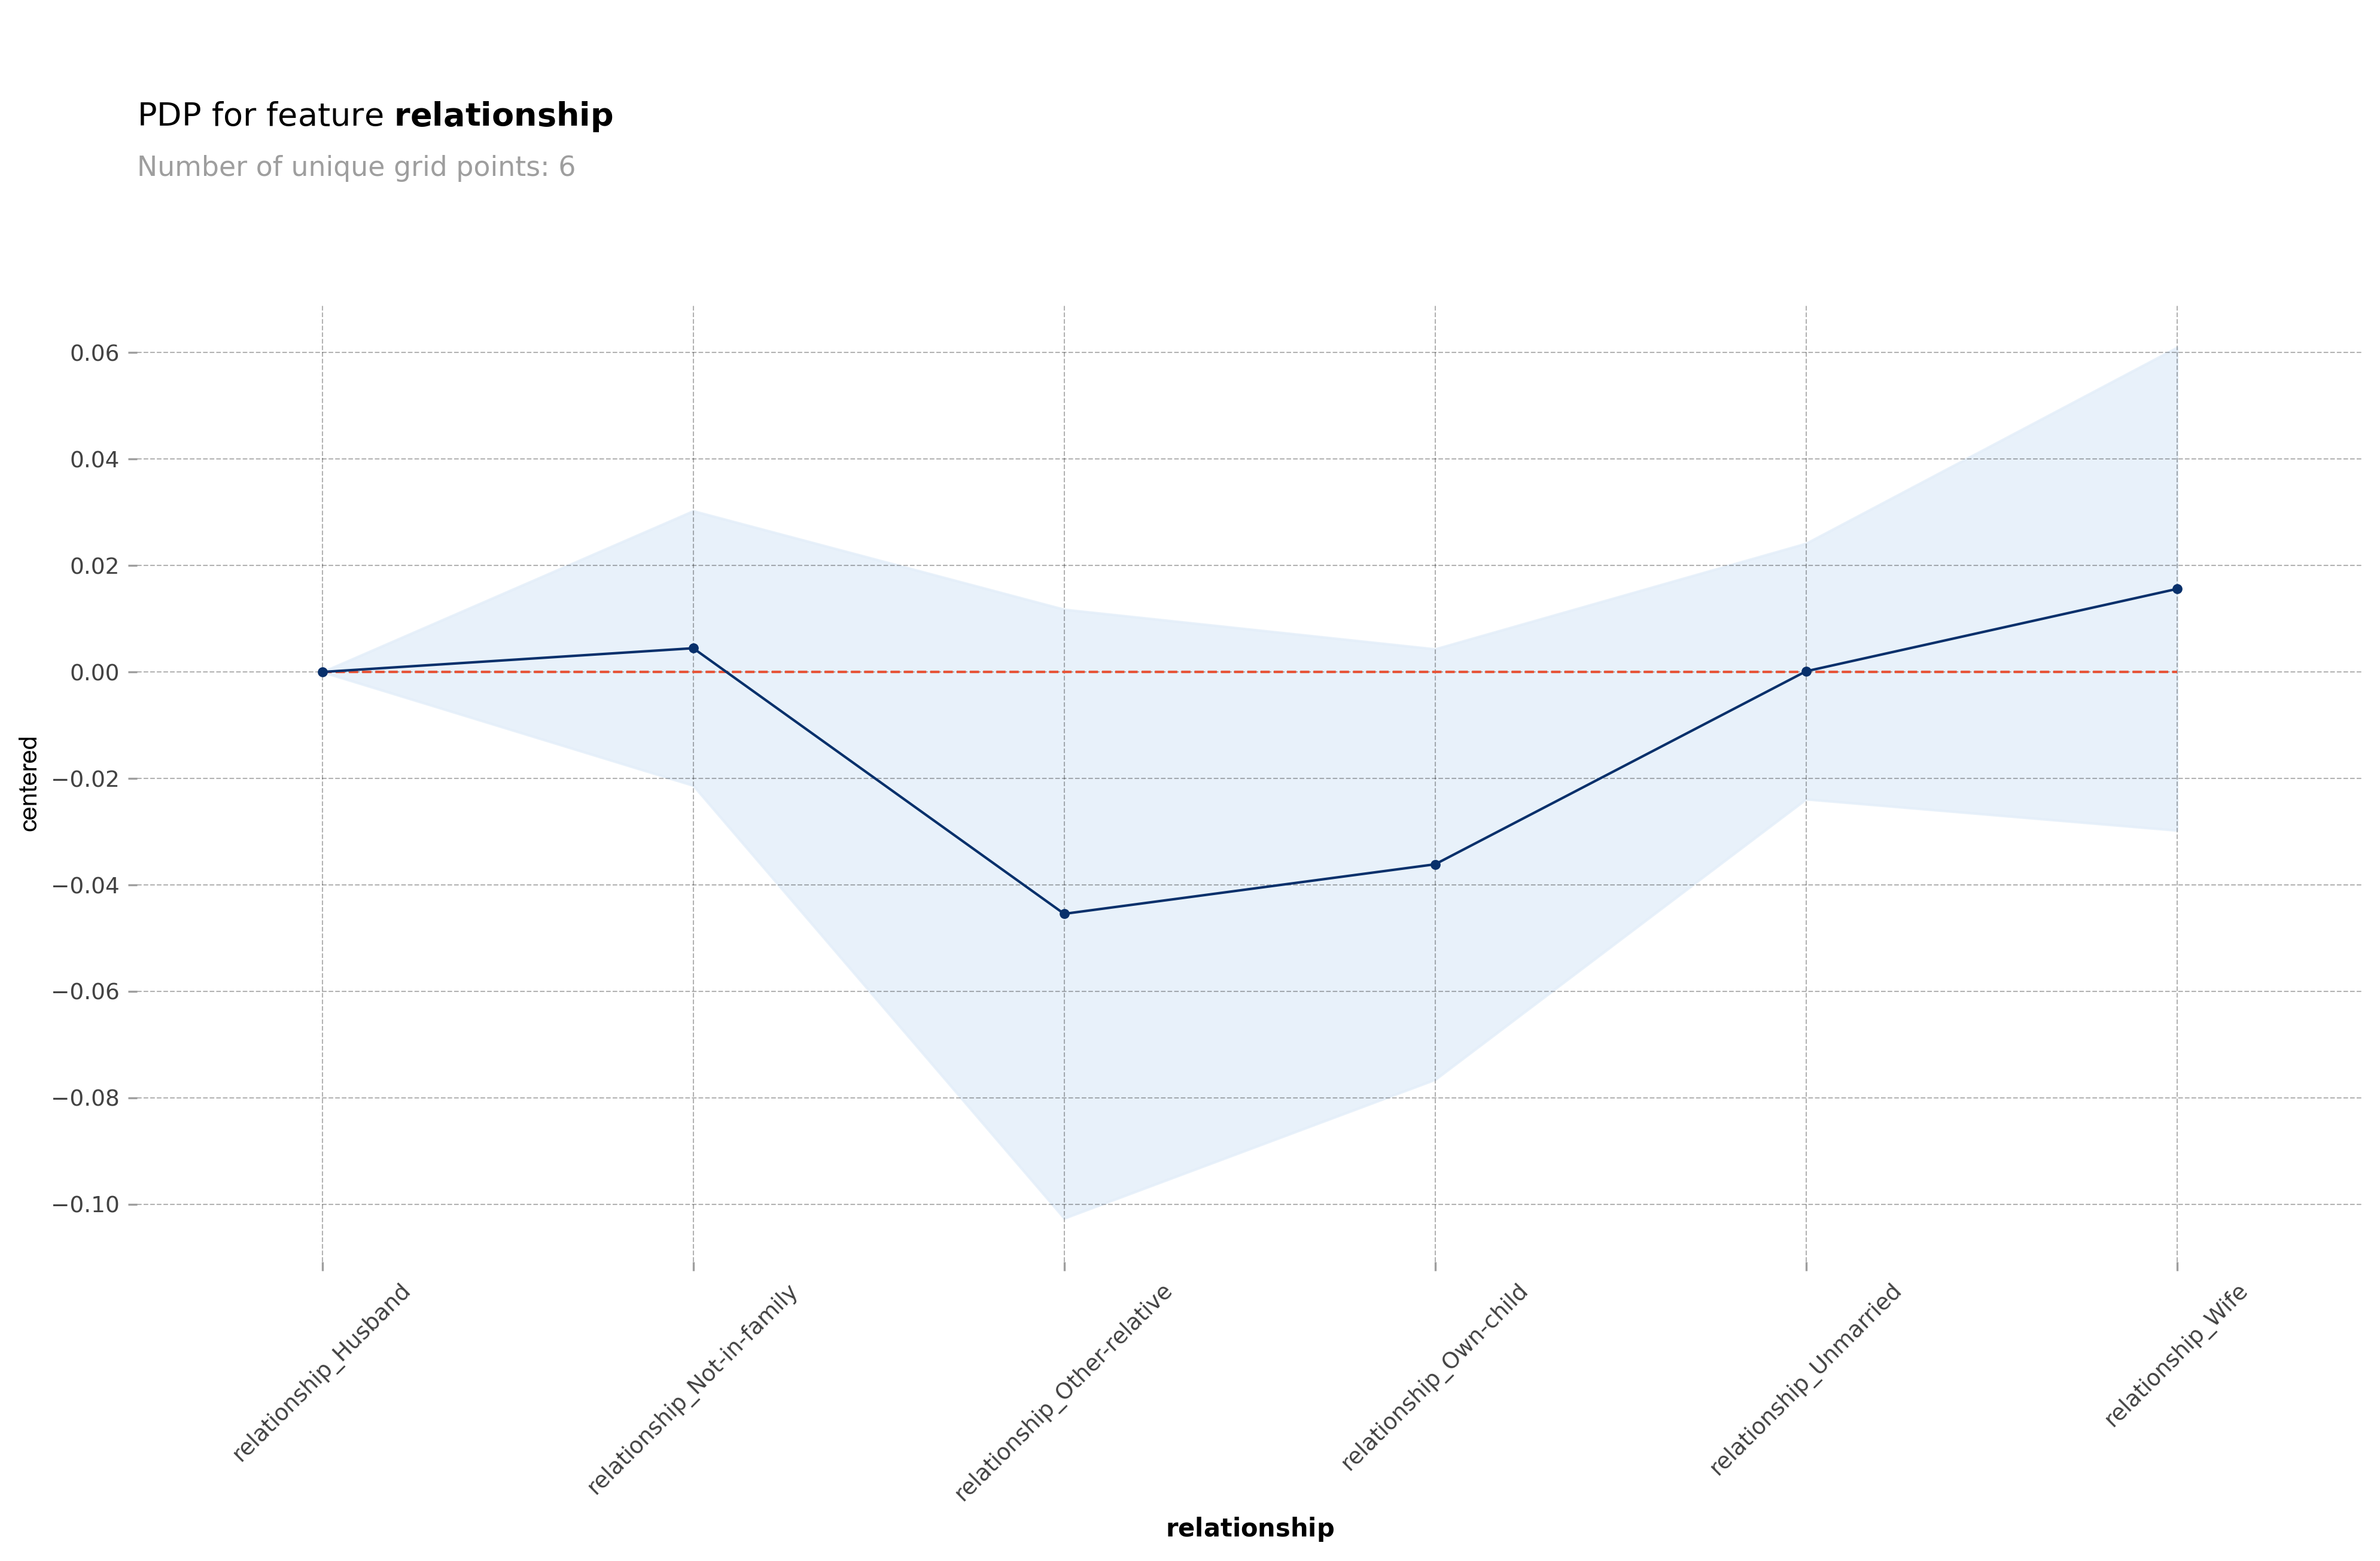

In [130]:
# relationship categorical
rel_columns = [col for col in X_full.columns if col.startswith("relationship_")]


# categorical feature
X_full_copy = X_full.copy()

pdp_rel = pdp.PDPIsolate(
    model=catboost_final,
    df=X_full_copy,
    model_features=X_full_copy.columns,
    feature=rel_columns,
    feature_name="relationship",
    data_transformer=data_trans,
    n_classes=2,
)

fig, axes = pdp_rel.plot(
    center=True,
    frac_to_plot=100,
    cluster=False,
    n_cluster_centers=None,
    cluster_method="accurate",
    to_bins=False,
    show_percentile=True,
    which_classes=None,
    figsize=None,
    dpi=300,
    ncols=2,
    plot_params=None,
    engine="matplotlib",
    template="plotly_white",
)
plt.xticks(rotation=45)

plt.show()

In [ ]:
# education category not neded
# fnl_weight not needed those columns are useless

### Local-agonistic methods 

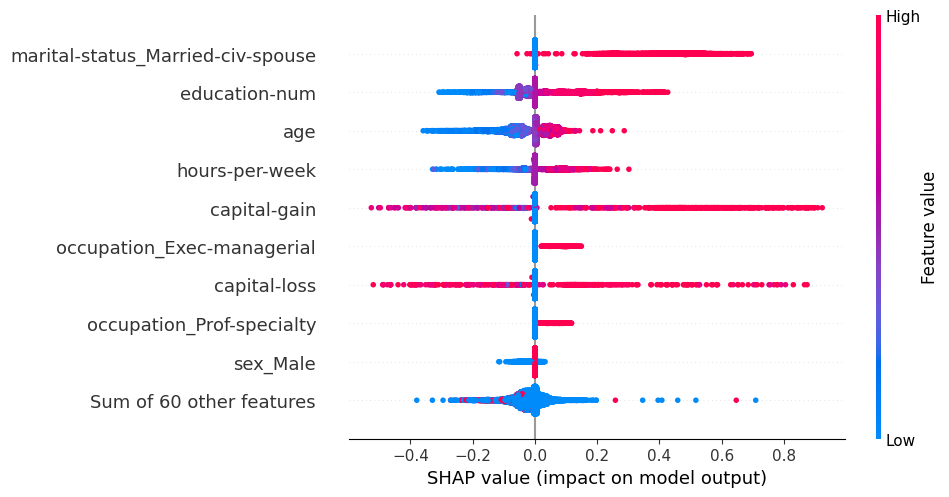

In [131]:
# SHAP Beeswarm Plot
shap.plots.beeswarm(shap_values)

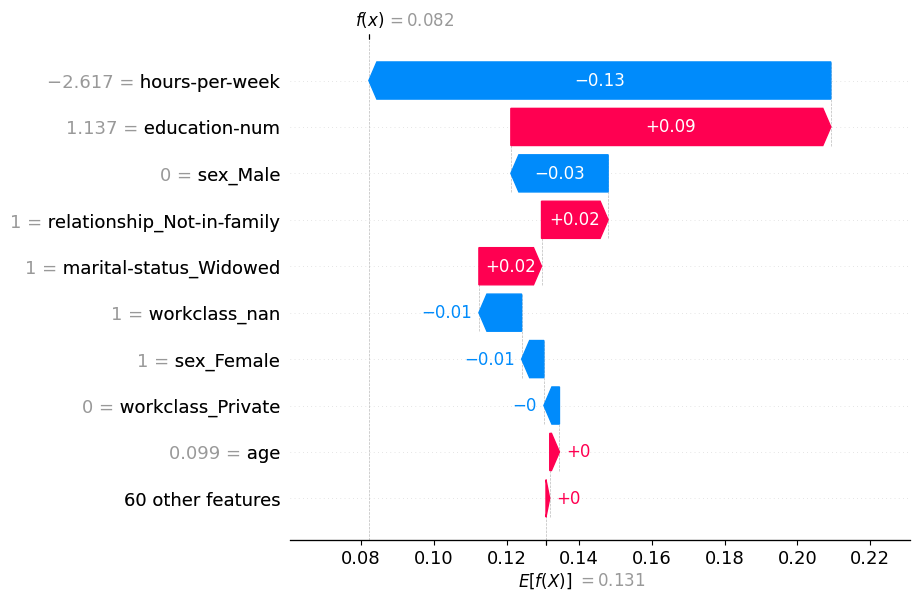

In [132]:
# SHAP Waterfall Plot (indvidual prediction)
shap.plots.waterfall(shap_values[12])

In [21]:
y_pred_proba = catboost_final.predict_proba(X_test_ss)[:, 1]
results = pd.DataFrame({"score": y_pred_proba})
results.index.name = "id"
results.to_csv("../40_results/catboost_prob.csv")

In [23]:
from sklearn.metrics import roc_curve, precision_recall_curve, auc

precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
f1_scores = 2 * (precision * recall) / (precision + recall)
max_f1_index = np.argmax(f1_scores)
max_threshold = thresholds[max_f1_index]
max_f1 = f1_scores[max_f1_index]
max_f1

0.7356274469400371